In [62]:
def get_args_parse():
    parser = argparse.ArgumentParser("")
    parser.add_argument("--naip_tile_df", default="/work/csr33/images_for_predictions/naip_tile_in_slosh_modeled_area.parquet", type=str)
    parser.add_argument("--processing_naip_df", default="/work/csr33/images_for_predictions/processed_naip_data.parquet", type=str)
    parser.add_argument("--chunked_naip_data_dir", default="/work/csr33/images_for_predictions/chunked_naip_data", type=str)

    parser.add_argument("--imgsz", default=640, type=int)
    args = parser.parse_args()
    output_directory = ''

    return args

import sys
sys.argv = ['my_notebook']
args = get_args_parse()
# Define the number of chunks
naip_df = pd.read_parquet(args.naip_tile_df) 

In [88]:
"/work/csr33/images_for_predictions/processed_naip_data_01.parquet"


'01'

In [76]:

# Use numpy.array_split to split the DataFrame into chunks

In [79]:
len(df_chunks)*500

14500

In [ ]:


# Specify the directory where you want to save the files

# Iterate through the chunks and write each chunk to a separate CSV file
for i, chunk in enumerate(df_chunks):
    # Construct the filename for the current chunk
    filename = f'{output_directory}chunk_{i}.csv'
    
    # Write the chunk to a CSV file
    chunk.to_csv(filename, index=False)
    
    print(f"Chunk {i} written to {filename}")

In [2]:
os.chdir("/work/csr33/object_detection")

In [3]:
def chunk_dataframe(df, chunksize):
    """
    Split dataframe into chunks of specified size.
    Args:
        df (pandas.DataFrame): DataFrame to chunk 
        chunksize (int): Size of each chunk
    Returns:
        generator: A generator yielding the chunked dataframes
    """

    for i in range(0, len(df), chunksize):
        yield df.iloc[i:i + chunksize]

In [5]:
def get_args_parse():
    parser = argparse.ArgumentParser("")
    parser.add_argument("--model_path", default="/work/csr33/object_detection/runs/detect/baseline_train/weights/best.pt", type=str)
    parser.add_argument("--processing_naip_df", default="/work/csr33/images_for_predictions/processed_naip_data.parquet", type=str)
    parser.add_argument("--imgsz", default=640, type=int)
    args = parser.parse_args()
    return args

import sys
sys.argv = ['my_notebook']
args = get_args_parse()

In [6]:
def reformat_data_chunk(df_chunk, args):
    df_chunk["y_coords"] = df_chunk["y_coords"].apply(bytestring_to_array)
    df_chunk["x_coords"] = df_chunk["x_coords"].apply(bytestring_to_array)
    df_chunk["split_tile_values"] = df_chunk["split_tile_values"].apply(bytestring_to_array)
    df_chunk["split_tile_values"] = df_chunk["split_tile_values"].apply(lambda v: v.reshape((args.imgsz, args.imgsz, 3)))
    return df_chunk
# Convert bytes to string 

def bytestring_to_array(bytestring):
    if type(bytestring) == bytes:
        decoded_string = bytestring.decode("utf-8")
        # Use ast.literal_eval to safely evaluate the string to a Python object
        list_obj = np.array(ast.literal_eval(decoded_string))
        return list_obj
    else: 
        return bytestring
    
    
def run_prediction(model, df_chunk):
    #predict
    conf_list = []
    class_list = []
    utm_bboxes_list = []
    lon_lat_bbox_list = []
    split_tile_values = [s.astype(np.uint8) for s in df_chunk["split_tile_values"]] #remove after preidct is run again
    results = model.predict(split_tile_values, save=False, imgsz=args.imgsz)#, conf=0.5)
    # process predictions
    for result, x_coords, y_coords, crs in zip(results, df_chunk["x_coords"].to_list(), 
                                               df_chunk["y_coords"].to_list(), 
                                               df_chunk["crs"].to_list()):
        boxes = result.boxes
        if len(boxes) > 0:             
            xyxys = boxes.xyxy.cpu().detach().numpy() #read xmin,ymin,xmax,ymax coordinates to memory as a numpy array
            xyxys = np.round(xyxys).astype(np.int32)  - 1 # round so that it can be used for utm to lonlat conversion, check if zero indexed
            utm_bboxes = [bbox_coords_to_utm(x_coords, y_coords, xyxy) for xyxy in xyxys]
            utm_bboxes_list.extend(utm_bboxes)
            
            lon_lat_bbox = [convert_bbox_coords_utm_lat_lon(utm_bbox, crs) for utm_bbox in utm_bboxes]
            lon_lat_bbox_list.extend(lon_lat_bbox)
    
            class_list.extend(boxes.cls.cpu().detach().tolist())
            conf_list.extend(boxes.conf.cpu().detach().tolist())
            
    return pd.DataFrame({"class": class_list, "confidence":conf_list, "utm_bboxes": utm_bboxes_list,
                         "lon_lat_bboxes": lon_lat_bbox_list})#,  dtype=dtypes)

In [7]:
processed_naip = pd.read_parquet(args.processing_naip_df) 

In [8]:
model = YOLO(args.model_path)  # custom trained model 

In [60]:
predictions_df = pd.DataFrame()
for df_chunk in chunk_dataframe(processed_naip.iloc[0:100], chunksize=10):
    #print(df_chunk)
    df_chunk = reformat_data_chunk(copy(df_chunk), args)
    predictions_df = pd.concat([predictions_df, run_prediction(model, df_chunk)])


0: 640x640 (no detections), 1: 640x640 (no detections), 2: 640x640 (no detections), 3: 640x640 (no detections), 4: 640x640 (no detections), 5: 640x640 (no detections), 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 (no detections), 9: 640x640 (no detections), 24264.2ms
Speed: 5.5ms preprocess, 2426.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1: 640x640 (no detections), 2: 640x640 (no detections), 3: 640x640 (no detections), 4: 640x640 (no detections), 5: 640x640 (no detections), 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 (no detections), 9: 640x640 (no detections), 24562.5ms
Speed: 5.0ms preprocess, 2456.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1: 640x640 (no detections), 2: 640x640 (no detections), 3: 640x640 (no detections), 4: 640x640 (no detections), 5: 640x640 1 undefined_object, 6: 640x640 (no detections), 7: 640x640 (no detec

In [ ]:

return pd.DataFrame({"probs": probs_list, "utm_bboxes": utm_bboxes_list,
                     "lon_lat_bboxes": lon_lat_bbox_list})#,  dtype=dtypes)

In [ ]:
def get_index_slices(df, index_slices_file_path, slices=200):
    index_slices = sliced(range(len(df)), round(len(df)/slices))
    index_slices = [[i.start, i.stop-1] for i in index_slices]
    index_slices = pd.DataFrame(index_slices, columns = ["start","stop"])
    index_slices.index.name = 'ArrayTaskID'
    index_slices.to_csv(index_slices_file_path)#, sep='\t', mode='w')
    return index_slices

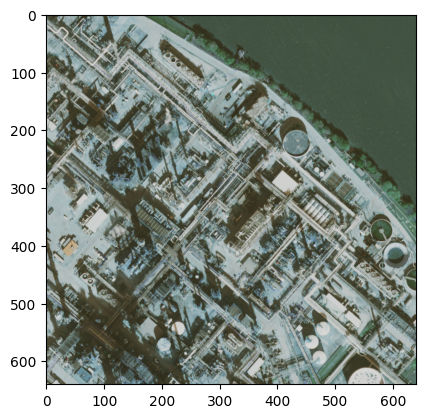

In [77]:
IPython.display.Image("/work/csr33/object_detection/runs/detect/predict27/image0.jpg")
plt.imshow(split_tile_values[159]) #rows (y), columns (x)
#plt.imshow(split_tile_values[159][xyxy[0][1]:xyxy[0][3], xyxy[0][0]:xyxy[0][2]]) #rows (y), columns (x)
IPython.display.Image(url=naip_df.assets.iloc[0]["image"]["href"])
plt.imshow(split_tile_values[159][xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]) #rows (y), columns (x)
#IPython.display.Image(url = subset.assets.iloc[0]["rendered_preview"]["href"], width=500)
plt.imshow(split_tile_values[159][xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]) #rows (y), columns (x)
IPython.display.Image("/work/csr33/object_detection/runs/detect/predict21/image0.jpg")
plt.imshow(np.ascontiguousarray(np.transpose(tile.values, (1, 2, 0))[:, :, [2, 1, 0]] ) )

In [ ]:
numpynp.zeros((640,1280,3))	np.ndarray	HWC format with BGR channels uint8 (0-255).